In [134]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import math
import argparse
import numpy as np
from sklearn import linear_model
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import applications
from tensorflow.compat.v1.keras import layers
from tensorflow.compat.v1.keras import models

# from dvrl import data_loading
# from dvrl import dvrl
# from dvrl import dvrl_metrics
import data_loading
import dvrl
import dvrl_metrics
import dvrl_utils
import os
from sklearn import metrics
import matplotlib.pyplot as plt

In [21]:
# Data name (either cifar10 or cifar100)
data_name = "cifar100"

# The number of training and validation samples
dict_no = dict()
dict_no['train'] = 4000
dict_no['valid'] = 1000
dict_no['test'] = 2000

# Additional noise ratio
noise_rate = 0.2

# Checkpoint file name
checkpoint_file_name = "./tmp/model.ckpt"



In [23]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

 
 

def readClassName():
    file_path = "./cifar100/cifar-100-python/meta"
    dic = unpickle(file_path)
    '''
    b'fine_label_names'
    b'coarse_label_names'
    '''
    fine_label_names = dic[b'fine_label_names']
    coarse_label_names = dic[b'coarse_label_names']
    return fine_label_names,coarse_label_names
 
if __name__=="__main__":
    f,c = readClassName()
    print(f)
    print(c)

[b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'road', b'rocket', b'rose', b'sea', b'seal', b'shark', b'shrew', b'skunk', b'skyscraper', b'snail', b'snake', b'spider', b'squirrel', b'streetcar', b'sunflower', b'sweet_pepper', b'table', b'tank', b'telephone', b'television', b'ti

In [25]:
import numpy as np
import cv2
# import class_name
 
image_no = 10
 
def arraytoimage(image):
    r = image[0:1024]
    g = image[1024:2048]
    b = image[2048:]
 
    r = np.reshape(r, (32, 32))
    g = np.reshape(g, (32, 32))
    b = np.reshape(b, (32, 32))
    image = cv2.merge([r,g,b])
    return image
 
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
 
def load_train_data():
    file_path = "./cifar100/cifar-100-python/train"
    train_data = unpickle(file_path)
    '''
    b'filenames'
    b'batch_label'
    b'fine_labels'
    b'coarse_labels'
    b'data'
    '''
 
    # 因为fine这个细标签就是了，他的范围为0-99的，我直接做一个中文对应就好
    f, c = readClassName()
    data = train_data[b'data']
    coarse_labels = train_data[b'coarse_labels']
 
    datas = []
    labels = []
    for i in range(len(data)):
        datas.append(arraytoimage(data[i]))
        labels.append(coarse_labels[i])
 
    datas = np.reshape(datas, (50000, 32, 32, 3))
    labels = np.reshape(labels, (50000, 1))
    return datas, labels
 
def load_test_data():
    file_path = "./cifar100/cifar-100-python/test"
    train_data = unpickle(file_path)
 
    f, c = readClassName()
    data = train_data[b'data']
    coarse_labels = train_data[b'coarse_labels']
 
    datas = []
    labels = []
    for i in range(len(data)):
        datas.append(arraytoimage(data[i]))
        labels.append(coarse_labels[i])
 
    # print(np.shape(datas))
    # print(np.shape(labels))
    datas = np.reshape(datas, (10000, 32, 32, 3))
    labels = np.reshape(labels, (10000, 1))
    return datas, labels
 
def load_data():
    train_data,train_label=load_train_data()
    test_data,test_label=load_test_data()
    return (train_data,train_label),(test_data,test_label)
 
 
if __name__=="__main__":
    (x_train, y_train), (x_test, y_test) = load_data()

In [30]:
# Splits train, valid and test sets
train_idx = np.random.permutation(len(x_train))

valid_idx = train_idx[:dict_no['valid']]
train_idx = train_idx[dict_no['valid']:(dict_no['train'] + dict_no['valid'])]

test_idx = np.random.permutation(len(x_test))[:dict_no['test']]

x_valid = x_train[valid_idx]
x_train = x_train[train_idx]
x_test = x_test[test_idx]

y_valid = y_train[valid_idx].flatten()
y_train = y_train[train_idx].flatten()
y_test = y_test[test_idx].flatten()

# Adds noise on labels
y_train, noise_idx = dvrl_utils.corrupt_label(y_train, noise_rate)

# Saves data
if not os.path.exists('data_files'):
    os.makedirs('data_files')

np.savez_compressed('./data_files/train.npz',
                    x_train=x_train, y_train=y_train)
np.savez_compressed('./data_files/valid.npz',
                    x_valid=x_valid, y_valid=y_valid)
np.savez_compressed('./data_files/test.npz',
                    x_test=x_test, y_test=y_test)

In [31]:

# Extracts features and labels.
x_train, y_train, x_valid, y_valid, x_test, y_test = data_loading.load_image_data_from_file('train.npz', 'valid.npz', 'test.npz')
print('Finished data preprocess.')

Finished data preprocess.


In [32]:
 # Encodes samples
# The preprocessing function used on the pre-training dataset is also
# applied while encoding the inputs.
preprocess_function = applications.inception_v3.preprocess_input
input_shape = (299, 299)

In [33]:
def encoder_model(architecture='inception_v3', pre_trained_dataset='imagenet',
                      downsample_factor=8):
    """Returns encoder model.
    Defines the encoder model to learn the representations for image dataset.
    In this example, we are considering the InceptionV3 model trained on
    ImageNet dataset, followed by simple average pooling-based downsampling.
    Args:
      architecture: Base architecture of encoder model (e.g. 'inception_v3')
      pre_trained_dataset: The dataset used to pre-train the encoder model
      downsample_factor: Downsample factor for the outputs
    Raises:
      NameError: Returns name errors if architecture is not 'inception_v3'
    """
    tf_input = layers.Input(shape=(input_shape[0], input_shape[1], 3))
    if architecture == 'inception_v3':
        model = applications.inception_v3.InceptionV3(
            input_tensor=tf_input, weights=pre_trained_dataset, include_top=False)
        output_pooled = \
            layers.AveragePooling2D((downsample_factor, downsample_factor),
                                    strides=(downsample_factor,
                                             downsample_factor))(model.output)
    else:
        raise NameError('Invalid architecture')
    return models.Model(model.input, output_pooled)


In [34]:
# Encodes training samples
print('---------enc_x_train  编码train数据-----------')
enc_x_train = data_loading.encode_image(x_train, encoder_model, input_shape, preprocess_function)

---------enc_x_train  编码train数据-----------
Instructions for updating:
Colocations handled automatically by placer.
126/126 [==============================] - 352s 3s/step


In [35]:
# Encodes validation samples
print('---------enc_x_train  编码valid数据-----------')
enc_x_valid = data_loading.encode_image(x_valid, encoder_model, input_shape, preprocess_function)

---------enc_x_train  编码valid数据-----------


Exception ignored in: <function BaseSession._Callable.__del__ at 0x0000014643298A68>
Traceback (most recent call last):
  File "E:\Anaconda3\envs\py_dvrl\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "E:\Anaconda3\envs\py_dvrl\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


63/63 [==============================] - 146s 2s/step


In [36]:
# Encodes testing samples
print('---------enc_x_train  编码test数据-----------')
enc_x_test = data_loading.encode_image(x_test, encoder_model, input_shape, preprocess_function)

---------enc_x_train  编码test数据-----------


Exception ignored in: <function BaseSession._Callable.__del__ at 0x0000014643298A68>
Traceback (most recent call last):
  File "E:\Anaconda3\envs\py_dvrl\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "E:\Anaconda3\envs\py_dvrl\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


126/126 [==============================] - 329s 3s/step


In [37]:
np.savez_compressed('./cifar100/enc_x_train0427.npz',
                        enc_x_train=enc_x_train)
np.savez_compressed('./cifar100/enc_x_valid0427.npz',
                        enc_x_valid=enc_x_valid)
np.savez_compressed('./cifar100/enc_x_test0427.npz',
                        enc_x_test=enc_x_test)

In [38]:
# Run DVRL
# Resets the graph
tf.reset_default_graph()
keras.backend.clear_session()

In [39]:
# Network parameters
parameters = dict()
parameters['hidden_dim'] = 100
parameters['comb_dim'] = 10
parameters['activation'] = tf.nn.relu
parameters['iterations'] = 2000
parameters['layer_number'] = 5
parameters['batch_size'] = 2000
parameters['learning_rate'] = 0.01
parameters['inner_iterations'] = 100
parameters['batch_size_predictor'] = 256

# python main_dvrl_image_transfer_learning.py --data_name cifar10 --train_no 4000 --valid_no 1000 --test_no 2000 
# --noise_rate 0.2 --hidden_dim 100 --comb_dim 10 --iterations 2000 --layer_number 5 --batch_size 2000 --inner_iterations 100 
# --batch_size_predictor 256 --learning_rate 0.01 --checkpoint_file_name ./tmp/model.ckpt

In [40]:
# Defines problem
problem = 'classification'

# Defines predictive model
pred_model = keras.models.Sequential()
pred_model.add(keras.layers.Dense(len(set(y_train)), activation='softmax'))
pred_model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [41]:
# Flags for using stochastic gradient descent / pre-trained model
flags = {'sgd': True, 'pretrain': False}

In [42]:
# Initalizes DVRL
dvrl_class = dvrl.Dvrl(enc_x_train, y_train, enc_x_valid, y_valid,
                       problem, pred_model, parameters,
                       checkpoint_file_name, flags)

Instructions for updating:
Use tf.cast instead.


Exception ignored in: <function BaseSession._Callable.__del__ at 0x0000014643298A68>
Traceback (most recent call last):
  File "E:\Anaconda3\envs\py_dvrl\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "E:\Anaconda3\envs\py_dvrl\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


In [43]:
dvrl_class.train_dvrl('accuracy')

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [2:20:38<00:00,  4.22s/it]


In [44]:
# Outputs
# Data valuation
dve_out = dvrl_class.data_valuator(enc_x_train, y_train)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt


In [47]:
dve_out.shape

(2000,)

In [48]:
np.save(file='./cifar100/dve_out220427.npy',arr=dve_out)

In [ ]:
------------------------------------------------------------------------------

In [50]:
dve_out

array([0.44655517, 0.4455167 , 0.43747973, ..., 0.45272243, 0.4349086 ,
       0.45324403], dtype=float32)

In [167]:
x_train.shape

(2000, 32, 32, 3)

In [8]:
# Loads images datasets
train = np.load('./cifar10/train.npz')
valid = np.load('./cifar10/valid.npz')
test = np.load('./cifar10/test.npz')

# Divides features and labels
x_train = train['x_train']
y_train = train['y_train']

x_valid = valid['x_valid']
y_valid = valid['y_valid']

x_test = test['x_test']
y_test = test['y_test']

In [9]:
train = np.load('./cifar100/220426-2/enc_x_train0426.npz' )
valid = np.load('./cifar100/220426-2/enc_x_valid0426.npz' )
test = np.load('./cifar100/220426-2/enc_x_test0426.npz' )
enc_x_train = train['enc_x_train']
enc_x_valid = valid['enc_x_valid']
enc_x_test = test['enc_x_test']

In [10]:
dve_out = np.load('./cifar100/220426-2/dve_out220426.npy')

In [ ]:
----------------------------------------------------------------------------------------------------

### Logistics  —— dvrl训练   _  三项指标画图

In [65]:
# Evaluations
# Evaluation model
eval_model = linear_model.LogisticRegression(solver='lbfgs',
                                             multi_class='auto',
                                             max_iter=2000)

In [68]:
# Performance after removing high/low values
print("-------------------- Performance after removing high/low values---------------------------")
temp_output_acc_log,temp_output_f1_log,temp_output_recall_log = remove_high_low(dve_out, eval_model, enc_x_train, y_train,
                                 enc_x_valid, y_valid, enc_x_test, y_test)

-------------------- Performance after removing high/low values---------------------------


E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metr

In [71]:
def plot_acc_f1_recall(temp_output,y_label):
    num_bins = 20

    # Defines x-axis
    num_x = int(num_bins/2 + 1)
    x = [a*(1.0/num_bins) for a in range(num_x)]

    # Prediction performances after removing high or low values
    plt.figure(figsize=(6, 7.5))
    plt.plot(x, temp_output[:num_x, 1], 'o-')
    plt.plot(x, temp_output[num_bins:(num_bins+num_x), 1], 'x-')

    plt.xlabel('Fraction of Removed Samples', size=16)
    plt.ylabel(y_label, size=16)
    plt.legend(['Removing low value data', 'Removing high value data'],
           prop={'size': 16})
    plt.title('Remove High/Low Valued Samples', size=16)

    plt.show()

    print("remove low:", temp_output[:20])
    print("remove high:",temp_output[21:])


#### Logistics  Accuracy  plot

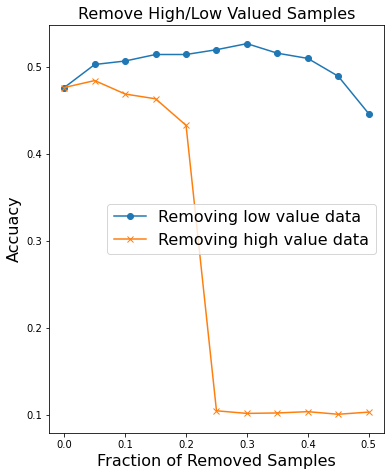

remove low: [[0.404  0.4765]
 [0.431  0.503 ]
 [0.447  0.507 ]
 [0.444  0.5145]
 [0.428  0.5145]
 [0.428  0.52  ]
 [0.434  0.527 ]
 [0.422  0.516 ]
 [0.411  0.51  ]
 [0.386  0.4895]
 [0.37   0.4465]
 [0.331  0.417 ]
 [0.291  0.37  ]
 [0.136  0.1915]
 [0.104  0.1145]
 [0.048  0.0435]
 [0.049  0.046 ]
 [0.058  0.0495]
 [0.068  0.0565]
 [0.059  0.0475]]
remove high: [[0.419  0.4845]
 [0.42   0.469 ]
 [0.4    0.4635]
 [0.371  0.433 ]
 [0.091  0.1045]
 [0.092  0.1015]
 [0.094  0.102 ]
 [0.099  0.1035]
 [0.096  0.1005]
 [0.091  0.103 ]
 [0.077  0.0765]
 [0.064  0.065 ]
 [0.065  0.065 ]
 [0.061  0.0595]
 [0.042  0.054 ]
 [0.044  0.054 ]
 [0.038  0.034 ]
 [0.039  0.039 ]
 [0.033  0.046 ]]


In [73]:
plot_acc_f1_recall(temp_output_acc_log,'Accuacy')

#### Logistics  f1  plot

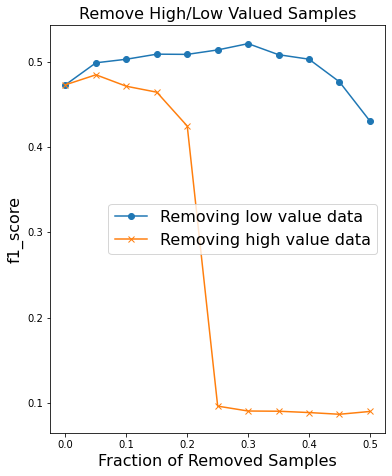

remove low: [[0.40778276 0.47276634]
 [0.43165134 0.49848224]
 [0.44743889 0.50266299]
 [0.4444971  0.50860497]
 [0.42841015 0.5083454 ]
 [0.4301364  0.51355257]
 [0.43675725 0.52092899]
 [0.4203078  0.50796484]
 [0.4094786  0.50271519]
 [0.38407228 0.47621299]
 [0.36562566 0.43042093]
 [0.32445398 0.39393282]
 [0.27235969 0.33138854]
 [0.12006006 0.16464957]
 [0.06365386 0.06714131]
 [0.01961371 0.0181011 ]
 [0.02269522 0.01993012]
 [0.02226019 0.01786349]
 [0.01748814 0.01324748]
 [0.02250901 0.01003978]]
remove high: [[0.42587474 0.48444609]
 [0.43234355 0.47102856]
 [0.41047458 0.46407458]
 [0.36955258 0.42441733]
 [0.08513681 0.09651656]
 [0.08440464 0.09078818]
 [0.08367083 0.09054152]
 [0.08664815 0.08899565]
 [0.08109123 0.08698203]
 [0.07843843 0.0902555 ]
 [0.07095105 0.07132706]
 [0.05690485 0.05833869]
 [0.05660097 0.05429258]
 [0.05188914 0.04930234]
 [0.0331623  0.04070134]
 [0.03031867 0.03817176]
 [0.0283052  0.02504919]
 [0.02728819 0.02690224]
 [0.01630728 0.02388512]

In [74]:
plot_acc_f1_recall(temp_output_f1_log,'f1_score')


#### Logistics  recall  plot

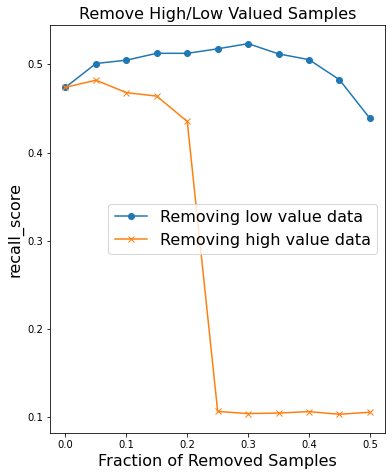

remove low: [[0.41244323 0.47396971]
 [0.43855782 0.50093736]
 [0.45429888 0.50473652]
 [0.4515011  0.51252941]
 [0.43520046 0.5124874 ]
 [0.43647531 0.51760067]
 [0.44261251 0.52347815]
 [0.43340012 0.51184308]
 [0.42321971 0.50533913]
 [0.40078123 0.48263582]
 [0.38413794 0.43882261]
 [0.34838184 0.40773523]
 [0.30832759 0.35881586]
 [0.14805174 0.18928231]
 [0.10684699 0.11075793]
 [0.04785746 0.04307387]
 [0.04959473 0.04508914]
 [0.05717393 0.04928305]
 [0.06407584 0.05647459]
 [0.05870273 0.0528448 ]]
remove high: [[0.42911184 0.48203644]
 [0.43055531 0.4679382 ]
 [0.40923252 0.46396044]
 [0.37752424 0.43524669]
 [0.09202617 0.10660717]
 [0.09278256 0.10422743]
 [0.09410694 0.10479535]
 [0.10238997 0.10643435]
 [0.10009117 0.10342898]
 [0.0945921  0.10574011]
 [0.07847948 0.0789625 ]
 [0.06487434 0.06727528]
 [0.06516877 0.06712286]
 [0.0633062  0.0602416 ]
 [0.04676662 0.05455223]
 [0.04877428 0.054667  ]
 [0.03884867 0.03449212]
 [0.03833914 0.03862923]
 [0.03298434 0.04532832]

In [75]:
plot_acc_f1_recall(temp_output_recall_log,'recall_score')


### KNN— — dvrl训练   _  三项指标画图

In [76]:
from sklearn.neighbors import KNeighborsClassifier
KNclf = KNeighborsClassifier()

In [77]:
# Performance after removing high/low values
print("-------------------- Performance after removing high/low values---------------------------")
temp_output_acc_KN,temp_output_f1_KN,temp_output_recall_KN = remove_high_low(dve_out, KNclf, enc_x_train, y_train,
                                 enc_x_valid, y_valid, enc_x_test, y_test)

-------------------- Performance after removing high/low values---------------------------


E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To s

E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 i

E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 i

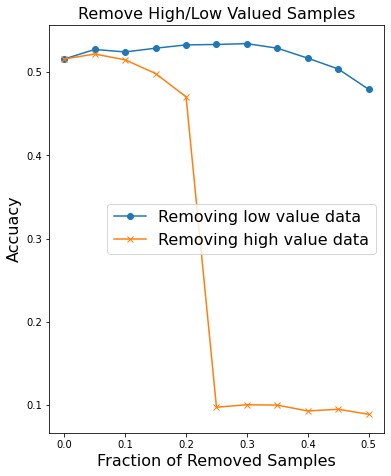

remove low: [[0.433  0.516 ]
 [0.449  0.5275]
 [0.456  0.5245]
 [0.457  0.529 ]
 [0.457  0.533 ]
 [0.462  0.5335]
 [0.452  0.5345]
 [0.451  0.529 ]
 [0.435  0.517 ]
 [0.427  0.504 ]
 [0.401  0.4795]
 [0.373  0.447 ]
 [0.316  0.402 ]
 [0.175  0.219 ]
 [0.12   0.1445]
 [0.06   0.048 ]
 [0.055  0.0565]
 [0.05   0.0485]
 [0.056  0.056 ]
 [0.053  0.0435]]
remove high: [[0.445  0.522 ]
 [0.438  0.515 ]
 [0.426  0.4985]
 [0.387  0.4705]
 [0.089  0.097 ]
 [0.092  0.1   ]
 [0.094  0.0995]
 [0.083  0.0925]
 [0.08   0.0945]
 [0.076  0.0885]
 [0.071  0.079 ]
 [0.065  0.065 ]
 [0.064  0.0645]
 [0.068  0.061 ]
 [0.06   0.052 ]
 [0.056  0.052 ]
 [0.055  0.061 ]
 [0.042  0.047 ]
 [0.027  0.036 ]]
--------------------------------------------------------------------------------------------


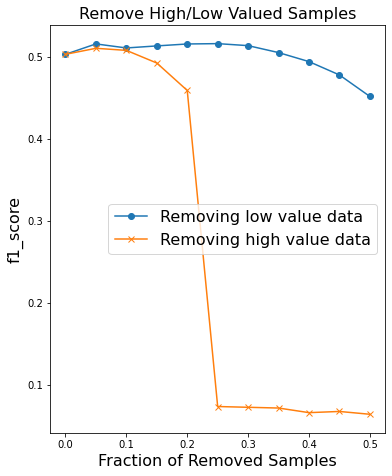

remove low: [[0.43082569 0.50370656]
 [0.4449162  0.51642079]
 [0.45200181 0.5114798 ]
 [0.45144365 0.51398229]
 [0.45054685 0.5163535 ]
 [0.4545122  0.51676874]
 [0.44506303 0.51431095]
 [0.44328222 0.50583006]
 [0.42623539 0.49480099]
 [0.41731259 0.47850024]
 [0.3916275  0.45222066]
 [0.35825708 0.41438007]
 [0.28683924 0.35504342]
 [0.16022277 0.19064897]
 [0.07415924 0.09128508]
 [0.02543932 0.0215889 ]
 [0.02540419 0.02714434]
 [0.01188793 0.01455625]
 [0.01268836 0.01422686]
 [0.01105797 0.00951407]]
remove high: [[0.44583708 0.51106395]
 [0.44132812 0.50853258]
 [0.43174729 0.49307238]
 [0.38512329 0.45954799]
 [0.07100951 0.07324683]
 [0.07065326 0.07230848]
 [0.07162926 0.07139535]
 [0.06074954 0.06576645]
 [0.05949259 0.06721403]
 [0.05753242 0.06377786]
 [0.05066423 0.05614889]
 [0.04487614 0.04560923]
 [0.04326616 0.04453042]
 [0.04825605 0.04083928]
 [0.04155333 0.03276518]
 [0.03894171 0.03475948]
 [0.03914746 0.04195318]
 [0.02982585 0.02955091]
 [0.01506135 0.02053912]

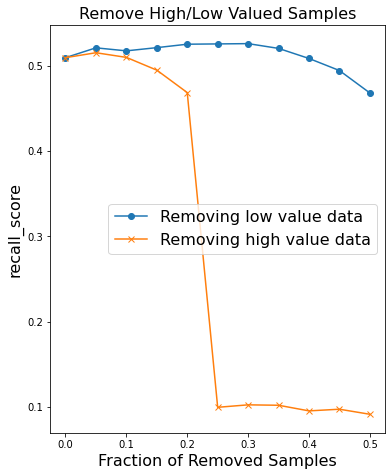

remove low: [[0.44623421 0.51000414]
 [0.46191921 0.52154645]
 [0.46976118 0.51799805]
 [0.47043347 0.52177851]
 [0.47119488 0.52580478]
 [0.47691698 0.52614674]
 [0.4669326  0.52648383]
 [0.4659186  0.52088543]
 [0.45266977 0.50905012]
 [0.44383847 0.49489709]
 [0.41927872 0.46855437]
 [0.39361301 0.43596483]
 [0.33782152 0.38846227]
 [0.18873836 0.21648749]
 [0.12742765 0.14066943]
 [0.0604337  0.0478037 ]
 [0.05598373 0.05567054]
 [0.04732143 0.04878545]
 [0.05103072 0.05578236]
 [0.0516038  0.04840125]]
remove high: [[0.45900754 0.51579505]
 [0.45089817 0.5103249 ]
 [0.43839594 0.49535259]
 [0.39550824 0.46899273]
 [0.09037209 0.09938052]
 [0.09341696 0.10226827]
 [0.09678671 0.10178071]
 [0.08423231 0.09518116]
 [0.0813846  0.09713483]
 [0.07759716 0.09119977]
 [0.07067118 0.08109553]
 [0.06526204 0.06666915]
 [0.06307068 0.06602513]
 [0.06792335 0.06239787]
 [0.06117593 0.05338267]
 [0.05676297 0.05355905]
 [0.0562686  0.06310168]
 [0.03996429 0.04865882]
 [0.02854758 0.03736619]

In [78]:
plot_acc_f1_recall(temp_output_acc_KN,'Accuacy')
print("--------------------------------------------------------------------------------------------")
plot_acc_f1_recall(temp_output_f1_KN,'f1_score')
print("--------------------------------------------------------------------------------------------")
plot_acc_f1_recall(temp_output_recall_KN,'recall_score')

### DCT— — dvrl训练   _  三项指标画图

In [79]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [80]:
# Performance after removing high/low values
print("-------------------- Performance after removing high/low values---------------------------")
temp_output_acc_DCT,temp_output_f1_DCT,temp_output_recall_DCT = remove_high_low(dve_out, dtc, enc_x_train,
                                                                                y_train,enc_x_valid, y_valid, 
                                                                                enc_x_test, y_test)

-------------------- Performance after removing high/low values---------------------------


E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence t

E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in l

E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in l

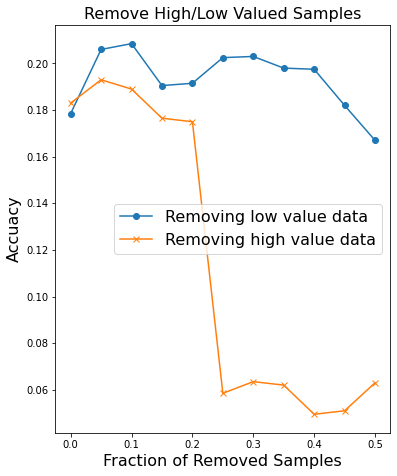

remove low: [[0.168  0.1785]
 [0.172  0.206 ]
 [0.172  0.2085]
 [0.176  0.1905]
 [0.194  0.1915]
 [0.188  0.2025]
 [0.18   0.203 ]
 [0.178  0.198 ]
 [0.169  0.1975]
 [0.155  0.182 ]
 [0.146  0.167 ]
 [0.157  0.167 ]
 [0.149  0.1565]
 [0.079  0.101 ]
 [0.08   0.0745]
 [0.056  0.0515]
 [0.047  0.056 ]
 [0.055  0.045 ]
 [0.055  0.047 ]
 [0.048  0.0485]]
remove high: [[0.191  0.193 ]
 [0.183  0.189 ]
 [0.161  0.1765]
 [0.149  0.175 ]
 [0.074  0.0585]
 [0.062  0.0635]
 [0.063  0.062 ]
 [0.058  0.0495]
 [0.051  0.051 ]
 [0.064  0.063 ]
 [0.049  0.05  ]
 [0.05   0.0465]
 [0.042  0.06  ]
 [0.058  0.046 ]
 [0.042  0.046 ]
 [0.042  0.0525]
 [0.053  0.038 ]
 [0.046  0.052 ]
 [0.029  0.041 ]]
--------------------------------------------------------------------------------------------


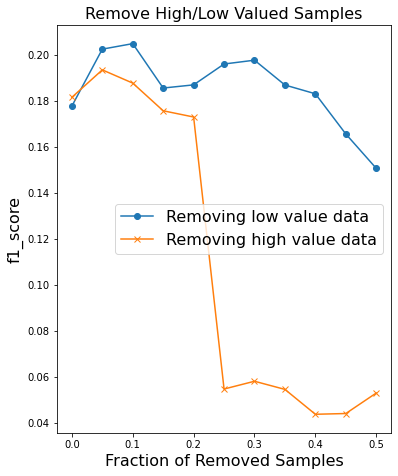

remove low: [[0.16976096 0.17775618]
 [0.17212326 0.20250204]
 [0.17066817 0.20489965]
 [0.17480724 0.18560912]
 [0.19570278 0.18698154]
 [0.1860719  0.19604537]
 [0.176373   0.19770555]
 [0.17658841 0.18691894]
 [0.16359981 0.18311156]
 [0.1515781  0.16565436]
 [0.13759239 0.15072001]
 [0.13496539 0.13694418]
 [0.12064284 0.12702786]
 [0.06277452 0.07243457]
 [0.05152159 0.04982237]
 [0.03189085 0.0281124 ]
 [0.02333967 0.02841265]
 [0.02643488 0.01865447]
 [0.03480986 0.02239208]
 [0.01828483 0.0189201 ]]
remove high: [[0.19430974 0.19349431]
 [0.18505204 0.18774805]
 [0.1519856  0.17572527]
 [0.15520182 0.17301991]
 [0.06847221 0.05483655]
 [0.05531415 0.05821039]
 [0.05418371 0.05467439]
 [0.04852533 0.04386856]
 [0.04206647 0.04419238]
 [0.05631296 0.05309081]
 [0.03817612 0.04221969]
 [0.03738589 0.03411618]
 [0.03307717 0.04804095]
 [0.04370484 0.03564334]
 [0.03388917 0.03458471]
 [0.03046905 0.03718278]
 [0.03878265 0.02814295]
 [0.02946156 0.03786383]
 [0.021272   0.0272726 ]

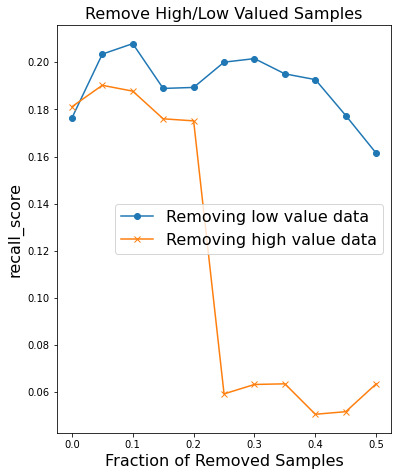

remove low: [[0.17249286 0.17633289]
 [0.17530513 0.20349537]
 [0.17521951 0.20794772]
 [0.18073857 0.18893037]
 [0.19819052 0.18935462]
 [0.19297588 0.20008183]
 [0.18172536 0.20158781]
 [0.18165163 0.19510915]
 [0.17899868 0.19267795]
 [0.1631744  0.17741468]
 [0.15333579 0.16140297]
 [0.16943666 0.16018989]
 [0.16404011 0.15019057]
 [0.08567686 0.0986364 ]
 [0.07957881 0.07297747]
 [0.05425781 0.05114123]
 [0.04500384 0.0550169 ]
 [0.05604    0.04464782]
 [0.05454978 0.04650712]
 [0.04768248 0.05250539]]
remove high: [[0.19661786 0.19025878]
 [0.18562031 0.18777728]
 [0.1589842  0.17603028]
 [0.1561148  0.17516953]
 [0.07643237 0.05925969]
 [0.06166622 0.06326231]
 [0.06413292 0.06353387]
 [0.05915872 0.05061148]
 [0.05180451 0.05171376]
 [0.06477416 0.06354219]
 [0.04740976 0.05138331]
 [0.04619806 0.04681603]
 [0.04117435 0.06059082]
 [0.0573535  0.04629971]
 [0.0417281  0.04597837]
 [0.04219336 0.05253502]
 [0.05089181 0.03813254]
 [0.04524332 0.05176492]
 [0.03073562 0.04118512]

In [81]:
plot_acc_f1_recall(temp_output_acc_DCT,'Accuacy')
print("--------------------------------------------------------------------------------------------")
plot_acc_f1_recall(temp_output_f1_DCT,'f1_score')
print("--------------------------------------------------------------------------------------------")
plot_acc_f1_recall(temp_output_recall_DCT,'recall_score')

### 随机去除样本做训练结果

In [57]:
from sklearn.neighbors import KNeighborsClassifier
KNclf = KNeighborsClassifier()

E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
E:\Anaconda3\envs\py_dvrl\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

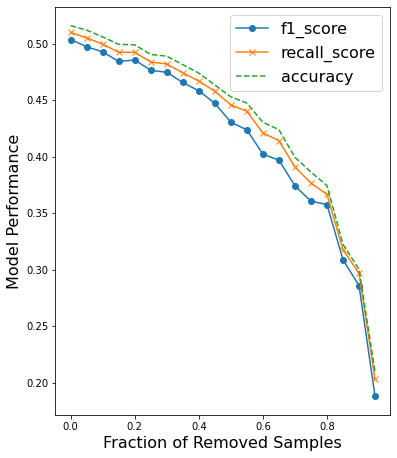

In [62]:
temp = remove_easy(KNclf,enc_x_train,y_train,enc_x_valid,y_valid,enc_x_test,y_test)

#### remove_easy

In [59]:
def remove_easy(eval_model, x_train, y_train,
                    x_valid, y_valid, x_test, y_test,
                    plot=True):
    x_train = np.asarray(x_train)
    y_train = np.reshape(np.asarray(y_train), [len(y_train),])
    x_valid = np.asarray(x_valid)
    y_valid = np.reshape(np.asarray(y_valid), [len(y_valid),])
    x_test = np.asarray(x_test)
    y_test = np.reshape(np.asarray(y_test), [len(y_test),])

    # Sorts samples by data values
    num_bins = 20  # Per 100/20 percentile

    # Output Initialization

    temp_output1 = np.zeros([2 * num_bins, 2])
    temp_output2 = np.zeros([2 * num_bins, 2])
    temp_output3 = np.zeros([2 * num_bins, 2])
#         temp_output = np.ones([2 * num_bins, 2])

    # For each percentile bin
    for itt in range(num_bins):

        # 1. Remove least valuable samples first
        new_x_train = x_train[int(itt*len(x_train[:, 0])/num_bins):]
        new_y_train = y_train[int(itt*len(x_train[:, 0])/num_bins):]

        if len(np.unique(new_y_train)) > 1:
            eval_model.fit(new_x_train, new_y_train)
#             if perf_metric == 'f1_score':
            y_valid_hat = eval_model.predict_proba(x_valid)
            y_test_hat = eval_model.predict_proba(x_test)

            temp_output1[itt, 0] = metrics.f1_score(y_valid,np.argmax(y_valid_hat,
                                                                   axis=1),average='macro')
            temp_output1[itt, 1] =  metrics.f1_score(y_test, np.argmax(y_test_hat,
                                                                   axis=1),average='macro')
#             elif perf_metric == 'recall_score':
#                 y_valid_hat = eval_model.predict_proba(x_valid)
#                 y_test_hat = eval_model.predict_proba(x_test)
                
            temp_output2[itt, 0] = metrics.recall_score(y_valid,np.argmax(y_valid_hat,
                                                                       axis=1),average='macro')
            temp_output2[itt, 1] =  metrics.recall_score(y_test, np.argmax(y_test_hat,
                                                                       axis=1),average='macro')
# #             elif perf_metric == 'accuracy':
#             y_valid_hat = eval_model.predict_proba(x_valid)
#             y_test_hat = eval_model.predict_proba(x_test)

            temp_output3[itt, 0] = metrics.accuracy_score(y_valid,
                                                         np.argmax(y_valid_hat,
                                                                   axis=1))
            temp_output3[itt, 1] = metrics.accuracy_score(y_test,
                                                         np.argmax(y_test_hat,
                                                               axis=1))
#             elif perf_metric == 'rmspe':
#                 y_valid_hat = eval_model.predict(x_valid)
#                 y_test_hat = eval_model.predict(x_test)

#                 temp_output[itt, 0] = rmspe(y_valid, y_valid_hat)
#                 temp_output[itt, 1] = rmspe(y_test, y_test_hat)
    # Plot graphs
    if plot:

        # Defines x-axis
        num_x = 20
        x = [a*(1.0/num_bins) for a in range(num_x)]

        # Prediction performances after removing high or low values
        plt.figure(figsize=(6, 7.5))
        plt.plot(x, temp_output1[:20, 1], 'o-')
        plt.plot(x, temp_output2[:20, 1], 'x-')
        plt.plot(x, temp_output3[:20, 1], '--')

        plt.xlabel('Fraction of Removed Samples', size=16)
        plt.ylabel('Model Performance', size=16)
        plt.legend(['f1_score', 'recall_score','accuracy'],
                   prop={'size': 16})
        

        plt.show()

#     print("remove low:", temp_output[:20])
#     print("remove high:",temp_output[21:])
    return temp_output1

#### remove_high_low  画图

In [67]:
def remove_high_low(dve_out, eval_model, x_train, y_train,
                    x_valid, y_valid, x_test, y_test):
    """Evaluates performance after removing a portion of high/low valued samples.
    Args:
    dve_out: data values
    eval_model: evaluation model (object)
    x_train: training features
    y_train: training labels
    x_valid: validation features
    y_valid: validation labels
    x_test: testing features
    y_test: testing labels
    perf_metric: 'auc', 'accuracy', or 'rmspe'
    plot: print plot or not
    Returns:
    output_perf: Prediction performances after removing a portion of high
                 or low valued samples.
    """
   
    x_train = np.asarray(x_train)
    y_train = np.reshape(np.asarray(y_train), [len(y_train),])
    x_valid = np.asarray(x_valid)
    y_valid = np.reshape(np.asarray(y_valid), [len(y_valid),])
    x_test = np.asarray(x_test)
    y_test = np.reshape(np.asarray(y_test), [len(y_test),])

    # Sorts samples by data values
    num_bins = 20  # Per 100/20 percentile
    sort_idx = np.argsort(dve_out)  # 从小到大
    n_sort_idx = np.argsort(-dve_out)  # 从大到小
    temp_output_acc = np.zeros([2 * num_bins, 2])
    temp_output_recall = np.zeros([2 * num_bins, 2])
    temp_output_f1 = np.zeros([2 * num_bins, 2])
    

    # For each percentile bin
    for itt in range(num_bins):

        # 1. Remove least valuable samples first
        new_x_train = x_train[sort_idx[int(itt*len(x_train[:, 0])/num_bins):], :]
        new_y_train = y_train[sort_idx[int(itt*len(x_train[:, 0])/num_bins):]]

        if len(np.unique(new_y_train)) > 1:
            eval_model.fit(new_x_train, new_y_train)
            
            y_valid_hat = eval_model.predict_proba(x_valid)
            y_test_hat = eval_model.predict_proba(x_test)

            temp_output_f1[itt, 0] = metrics.f1_score(y_valid,np.argmax(y_valid_hat, axis=1),average='macro')
            temp_output_f1[itt, 1] =  metrics.f1_score(y_test, np.argmax(y_test_hat, axis=1),average='macro')
                
            temp_output_recall[itt, 0] = metrics.recall_score(y_valid,np.argmax(y_valid_hat,axis=1),average='macro')
            temp_output_recall[itt, 1] =  metrics.recall_score(y_test, np.argmax(y_test_hat, axis=1),average='macro')

            temp_output_acc[itt, 0] = metrics.accuracy_score(y_valid, np.argmax(y_valid_hat, axis=1))
            temp_output_acc[itt, 1] = metrics.accuracy_score(y_test, np.argmax(y_test_hat, axis=1))


        # 2. Remove most valuable samples first
        new_x_train = x_train[n_sort_idx[int(itt*len(x_train[:, 0])/num_bins):], :]
        new_y_train = y_train[n_sort_idx[int(itt*len(x_train[:, 0])/num_bins):]]

        if len(np.unique(new_y_train)) > 1:

            eval_model.fit(new_x_train, new_y_train)

            y_valid_hat = eval_model.predict_proba(x_valid)
            y_test_hat = eval_model.predict_proba(x_test)

            temp_output_f1[num_bins + itt, 0] = metrics.f1_score(y_valid, np.argmax(y_valid_hat, axis=1)  ,average='macro')
            temp_output_f1[num_bins + itt, 1] =  metrics.f1_score(y_test, np.argmax(y_test_hat, axis=1) ,average='macro')

            temp_output_recall[num_bins + itt, 0] = metrics.recall_score(y_valid,np.argmax(y_valid_hat,axis=1),average='macro')
            temp_output_recall[num_bins + itt, 1] =  metrics.recall_score(y_test, np.argmax(y_test_hat,axis=1),average='macro')

            temp_output_acc[num_bins + itt, 0] = metrics.accuracy_score(y_valid, np.argmax(y_valid_hat, axis=1))
            temp_output_acc[num_bins + itt, 1] = metrics.accuracy_score(y_test, np.argmax(y_test_hat, axis=1))
            
    return temp_output_acc,temp_output_f1,temp_output_recall
  

In [ ]:
# Plot graphs
if plot:

    # Defines x-axis
    num_x = int(num_bins/2 + 1)
    x = [a*(1.0/num_bins) for a in range(num_x)]

    # Prediction performances after removing high or low values
    plt.figure(figsize=(6, 7.5))
    plt.plot(x, temp_output[:num_x, 1], 'o-')
    plt.plot(x, temp_output[num_bins:(num_bins+num_x), 1], 'x-')

    plt.xlabel('Fraction of Removed Samples', size=16)
    plt.ylabel('recall_score', size=16)
    plt.legend(['Removing low value data', 'Removing high value data'],
               prop={'size': 16})
    plt.title('Remove High/Low Valued Samples', size=16)

    plt.show()

print("remove low:", temp_output[:20])
print("remove high:",temp_output[21:])
return temp_output

## 计算图片熵  、 对比度

In [82]:
def plot_images_labels_prediction(images,labels,idx):
    fig=plt.gcf()
    fig.set_size_inches(12,14)
    for i in range(0,10):
        ax = plt.subplot(5,5,i+1)
        ax.imshow(images[idx],cmap='binary') 
        title= str(i)+' '+ str(labels[i])
        
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx+=1
    plt.show()
 

In [83]:
label_dict = {
    0:'aquatic mammals',
    1:'fish ',
    2:'flowers ',
    3:'food containers  ',
    4:'fruit and vegetables ',
    5:'household electrical devices',
    6:'household furniture',
    7:'insects',
    8:'large carnivores',
    9:'large man-made outdoor things',
    10:'large natural outdoor scenes ',
    11:'large omnivores and herbivores ',
    12:'medium-sized mammals ',
    13:'non-insect invertebrates ',
    14:'people',
    15:'reptiles',
    16:'small mammals',
    17:'trees',
    18:'vehicles 1',
    19:'vehicles 2'
}

In [84]:
# Sorts samples by data values
num_bins = 20  # Per 100/20 percentile
sort_idx = np.argsort(dve_out)  # 从小到大
n_sort_idx = np.argsort(-dve_out)  # 从大到小

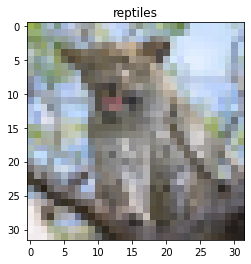

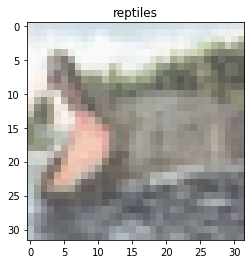

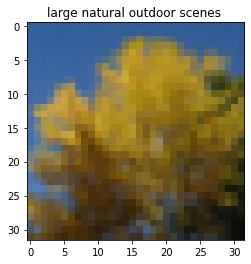

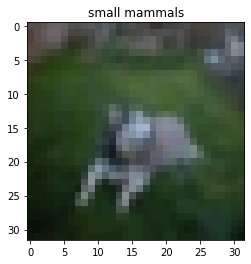

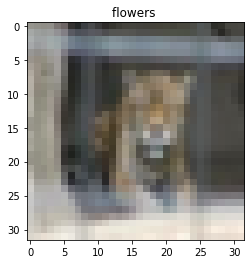

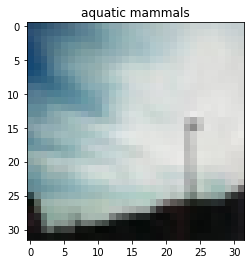

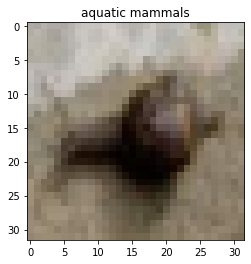

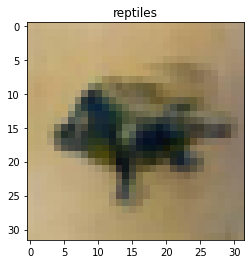

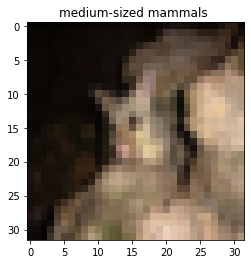

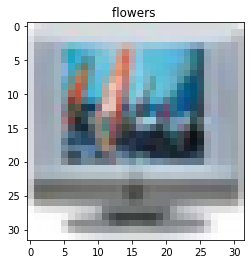

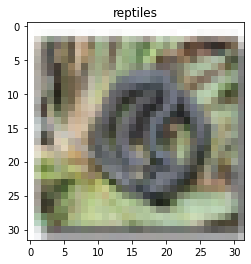

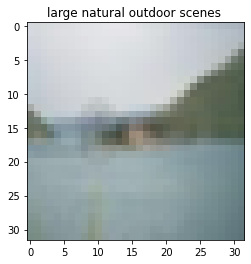

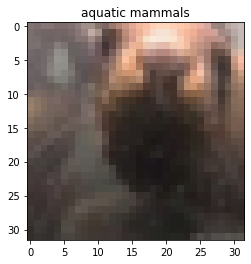

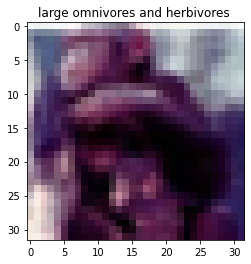

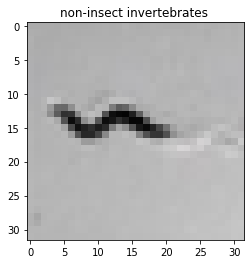

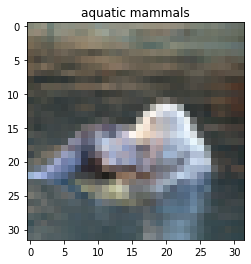

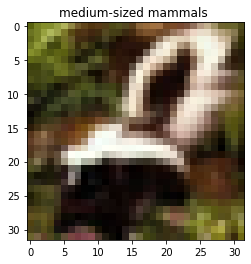

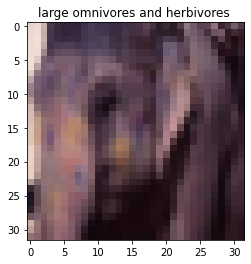

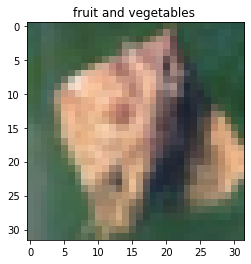

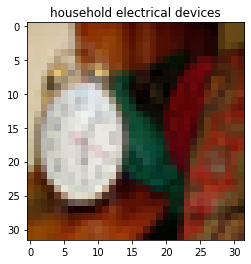

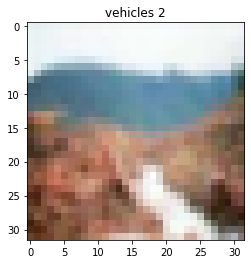

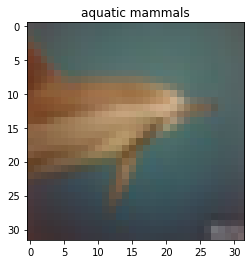

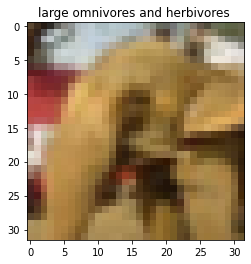

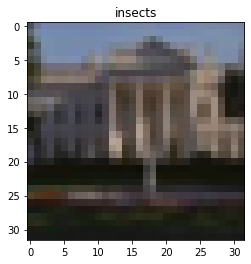

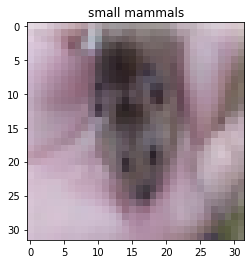

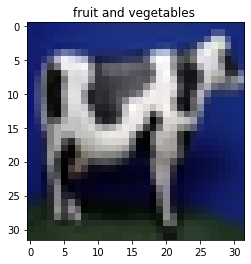

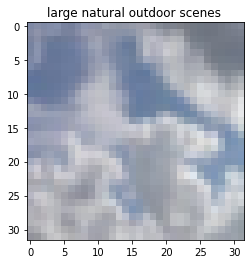

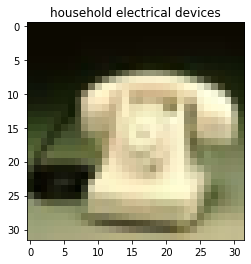

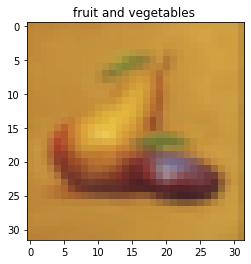

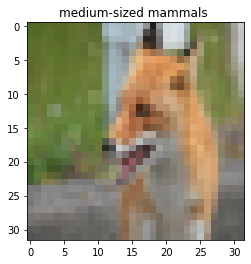

In [92]:
# 低价值画图
for i in range(30):
    plt.imshow(new_x_train[i,:,:,:])
    title= new_y_train[i]
    plt.title(label_dict[title])
    plt.show()

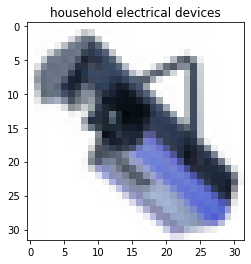

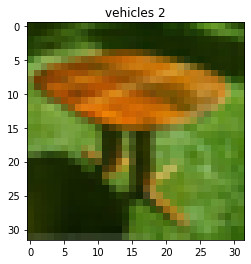

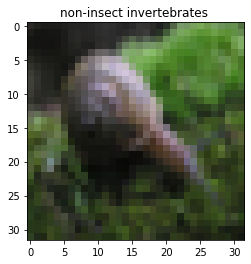

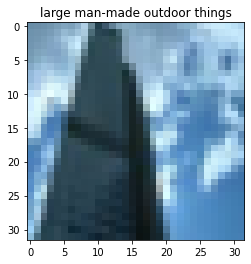

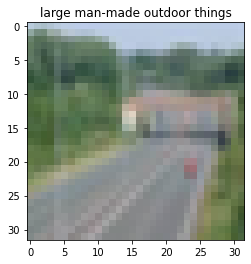

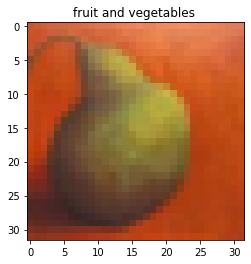

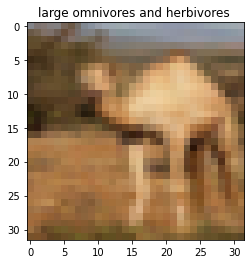

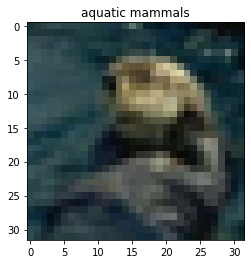

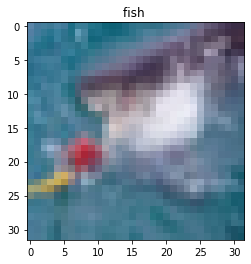

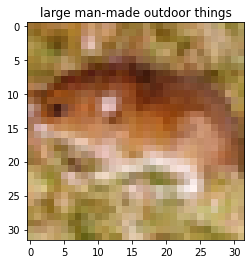

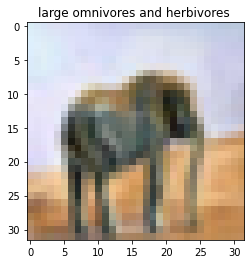

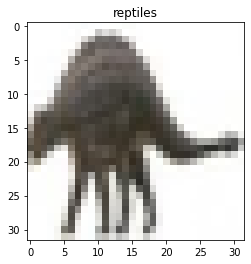

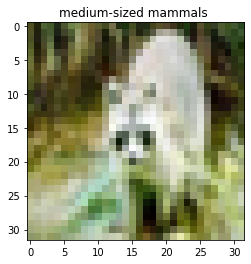

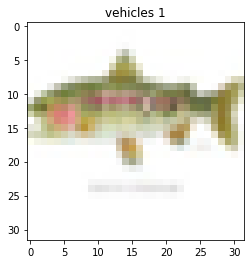

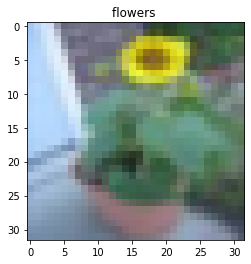

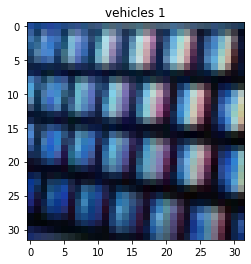

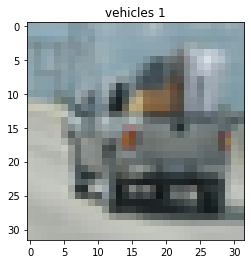

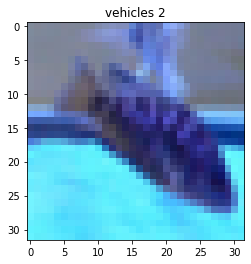

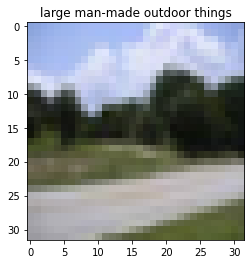

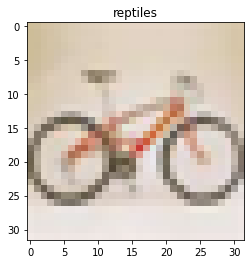

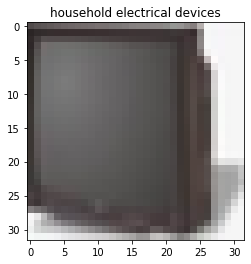

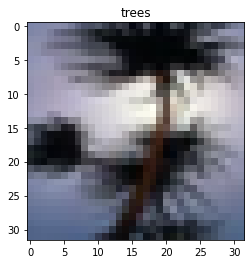

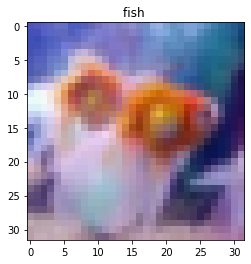

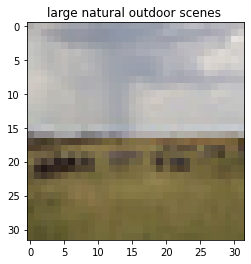

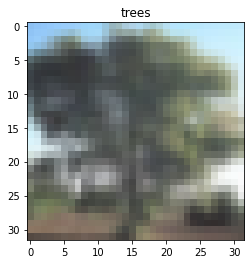

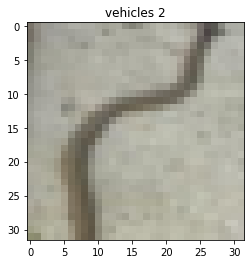

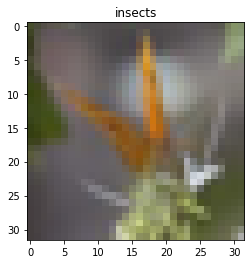

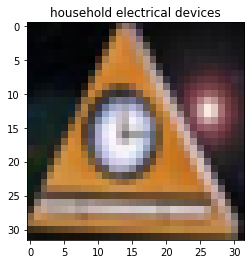

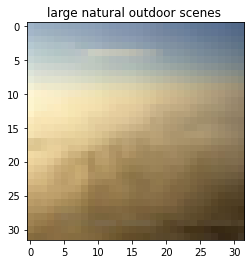

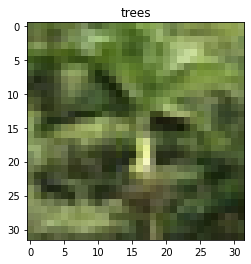

In [94]:
# 高价值画图
for i in range(30):
    
    plt.imshow(n_new_x_train[i,:,:,:])
    title= n_new_y_train[i]
    plt.title(label_dict[title])
    plt.show()

In [126]:
#计算熵函数
def entropy(X):
    n = len(X)

    counts = np.bincount(X)
    probs = counts[np.nonzero(counts)] / n

    en = 0
    for i in range(len(probs)):
        en = en - probs[i] * np.log(probs[i])/np.log(2)

    return en

In [161]:
itt  = 6

In [162]:
new_x_train=x_train[sort_idx[int(itt*len(x_train[:, 0])/num_bins):],:]
new_y_train = y_train[sort_idx[int(itt*len(x_train[:,0])/num_bins):]]

In [163]:
n_new_x_train = x_train[n_sort_idx[int(itt*len(x_train[:, 0])/num_bins):],:]
n_new_y_train = y_train[n_sort_idx[int(itt*len(x_train[:,0])/num_bins):]]

In [164]:
# 高价值
sum= 0
for j in range(200):
#     c_x_train = new_x_train[j].flatten()
#     res = 0
#     for i in range(len(c_x_train)):
#         if(c_x_train[i] == 0):
#             res = res
#         else:
#             res = float(res - c_x_train[i] * (math.log(c_x_train[i]) / math.log(2.0)))

#     print(res)
#     sum+=res
    c_x_train = n_new_x_train[j].reshape(32*32,3)
    data_B = c_x_train[:,0]
    data_G = c_x_train[:,1]
    data_R = c_x_train[:,2]
    B = entropy(data_B)
    G = entropy(data_G)
    R = entropy(data_R)
#     print(B)
#     print(G)
#     print(R)
    mean_rgb = (B+G+R)/3
    print("mean_rgb:",j,mean_rgb)
    sum += mean_rgb

mean_res = sum/200
print("mean:",mean_res)

mean_rgb: 0 6.9720101678517565
mean_rgb: 1 7.393793305346631
mean_rgb: 2 7.3276323922985265
mean_rgb: 3 7.672018516161256
mean_rgb: 4 6.360983149778147
mean_rgb: 5 6.687910576492754
mean_rgb: 6 7.297270184125064
mean_rgb: 7 7.064225461541496
mean_rgb: 8 7.543657180547053
mean_rgb: 9 6.866274503849908
mean_rgb: 10 6.898641435817095
mean_rgb: 11 5.446039993641321
mean_rgb: 12 6.833505866968282
mean_rgb: 13 7.194697740645583
mean_rgb: 14 6.973337162819754
mean_rgb: 15 7.455998939252936
mean_rgb: 16 6.790448098407135
mean_rgb: 17 5.9727976199146395
mean_rgb: 18 7.067537746000924
mean_rgb: 19 6.5855533598310485
mean_rgb: 20 7.213384124769445
mean_rgb: 21 7.244779820012263
mean_rgb: 22 7.110051716709893
mean_rgb: 23 7.262633748134636
mean_rgb: 24 5.903242739356986
mean_rgb: 25 7.06032661013005
mean_rgb: 26 7.347667318243599
mean_rgb: 27 6.280474550829212
mean_rgb: 28 4.896990718699676
mean_rgb: 29 6.524304501947046
mean_rgb: 30 6.7441487894317005
mean_rgb: 31 6.789005520677026
mean_rgb: 32 7

In [165]:
# 低价值
sum_low= 0
for j in range(200):
#     c_x_train = new_x_train[j].flatten()
#     res = 0
#     for i in range(len(c_x_train)):
#         if(c_x_train[i] == 0):
#             res = res
#         else:
#             res = float(res - c_x_train[i] * (math.log(c_x_train[i]) / math.log(2.0)))

#     print(res)
#     sum+=res
    c_x_train = new_x_train[j].reshape(32*32,3)
    data_B = c_x_train[:,0]
    data_G = c_x_train[:,1]
    data_R = c_x_train[:,2]
    B = entropy(data_B)
    G = entropy(data_G)
    R = entropy(data_R)
#     print(B)
#     print(G)
#     print(R)
    mean_rgb = (B+G+R)/3
    print("mean_rgb:",j,mean_rgb)
    sum_low += mean_rgb

mean_res = sum_low/200
print("mean:",mean_res)

mean_rgb: 0 6.3822531336002895
mean_rgb: 1 6.97620173709257
mean_rgb: 2 7.055095903227723
mean_rgb: 3 7.311193400326093
mean_rgb: 4 7.5685864898892286
mean_rgb: 5 7.138971766463384
mean_rgb: 6 7.33704365532913
mean_rgb: 7 6.785310230022304
mean_rgb: 8 7.39669673271483
mean_rgb: 9 6.616554368031285
mean_rgb: 10 7.245386753246684
mean_rgb: 11 6.156818158596075
mean_rgb: 12 7.594072893271193
mean_rgb: 13 6.288778500730018
mean_rgb: 14 7.252656355173461
mean_rgb: 15 3.0414897960219096
mean_rgb: 16 6.594129756604773
mean_rgb: 17 3.85810963957506
mean_rgb: 18 5.034568133074347
mean_rgb: 19 6.722436812703289
mean_rgb: 20 6.76701577075067
mean_rgb: 21 7.0956523907338
mean_rgb: 22 5.960314338324525
mean_rgb: 23 7.182207724332578
mean_rgb: 24 6.82549787762465
mean_rgb: 25 7.3533201970054
mean_rgb: 26 5.284070763960062
mean_rgb: 27 7.389218195180933
mean_rgb: 28 6.882529923950763
mean_rgb: 29 7.064898831304408
mean_rgb: 30 6.825059722777705
mean_rgb: 31 7.146758034169122
mean_rgb: 32 5.9415511752

In [130]:

#SMD梯度函数计算
def SMD(img):
    '''
    :param img:narray 二维灰度图像
    :return: float 图像越清晰越大
    '''
    shape = np.shape(img)
    out = 0
    for x in range(1, shape[0]-1):
        for y in range(0, shape[1]):
            out+=math.fabs(int(img[x,y])-int(img[x,y-1]))
            out+=math.fabs(int(img[x,y]-int(img[x+1,y])))
    return out


In [143]:
itt  = 7
new_x_train=x_train[sort_idx[int(itt*len(x_train[:, 0])/num_bins):],:]
new_y_train = y_train[sort_idx[int(itt*len(x_train[:,0])/num_bins):]]
n_new_x_train = x_train[n_sort_idx[int(itt*len(x_train[:, 0])/num_bins):],:]
n_new_y_train = y_train[n_sort_idx[int(itt*len(x_train[:,0])/num_bins):]]

In [144]:
# 低价值
sum_smd = 0
for i in range(30):
    #转为黑白
    image = tf.image.rgb_to_grayscale(new_x_train[i,:,:,:])
    image = tf.squeeze(image,2)
    # plt.imshow(image)
    with tf.Session():
        gray_image = image.eval()
    #     print(z_np)
    smd = SMD(gray_image)
    print(smd)
    sum_smd += smd
mean_smd = sum_smd/30
print("mean_smd:",mean_smd)

42521.0
30642.0
18850.0
16381.0
27696.0
19771.0
20613.0
16379.0
27628.0
33827.0
50158.0
12148.0
18022.0
31962.0
12130.0
29268.0
46912.0
28269.0
24365.0
29883.0
24694.0
8436.0
31307.0
24289.0
20149.0
43389.0
20255.0
31146.0
12366.0
24515.0
mean_smd: 25932.366666666665


In [145]:
# 高价值
sum_smd = 0
for i in range(30):
    #转为黑白
    image = tf.image.rgb_to_grayscale(n_new_x_train[i,:,:,:])
    image = tf.squeeze(image,2)
    # plt.imshow(image)
    with tf.Session():
        gray_image = image.eval()
    #     print(z_np)
    smd = SMD(gray_image)
    print(smd)
    sum_smd += smd
mean_smd = sum_smd/30
print("mean_smd:",mean_smd)

35942.0
26521.0
25570.0
30633.0
19809.0
10990.0
26671.0
26589.0
22897.0
31640.0
28297.0
37394.0
45297.0
18684.0
25264.0
56041.0
29230.0
22690.0
26472.0
30863.0
21375.0
35135.0
27003.0
14804.0
28477.0
16036.0
17950.0
39685.0
12516.0
35440.0
mean_smd: 27530.5
